In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE, r2_score



In [203]:
inputs_train = pd.read_csv("../../data/cleaned/unemp_inputs_train_det.csv")
# inputs_train = inputs_train.drop(columns=["id"], axis=1)

samples_train, features = inputs_train.shape 

labels_train = pd.read_csv("../../data/cleaned/unemp_labels_train_det.csv")
# labels_train = labels_train.drop(columns=["id"], axis=1)

inputs_test = pd.read_csv("../../data/cleaned/unemp_inputs_test_det.csv")
# inputs_test = inputs_test.drop(columns=["id"], axis=1)

samples_test, features = inputs_test.shape 

labels_test = pd.read_csv("../../data/cleaned/unemp_labels_test_det.csv")
# labels_test = labels_test.drop(columns=["id"], axis=1)

print(samples_train, samples_test)

615 145


In [204]:
# generates timestepped data for autorregression

def generate_timesteps(data, ind=1, out=1):
    cols, col_names = [], []
    
    if type(data) is list:
        vars = 1 
    else:
        vars = data.shape[1]
    df = pd.DataFrame(data)
    
    # input sequence of t-n to t-1
    for i in range(ind, 0, -1):
        cols.append(df.shift(i))
        col_names += [('var%d(t-%d)' % (j + 1, i)) for j in range(vars)]

    # forecast sequence of t to t+n
    for i in range(0, out):
        cols.append(df.shift(-i))
        if i == 0:
            col_names += [('var%d(t)' % (j + 1)) for j in range(vars)]
        else:
            col_names += [('var%d(t+%d)' % (j + 1, i)) for j in range(vars)]

    timestepped = pd.concat(cols, axis=1)
    timestepped.columns = col_names
    timestepped.dropna(inplace=True)
    return timestepped

In [205]:
# process data for autoregression

window_train = 1
window_test = 1

train_in, test_in = samples_train-window_train, samples_test-window_test

inputs_train = generate_timesteps(inputs_train.values, train_in, window_train)
print(inputs_train.shape)

inputs_test = generate_timesteps(inputs_test.values, test_in, window_test)
print(inputs_test.shape)

# roll by window size

inputs_train = inputs_train.rolling(window=window_train).mean().dropna()
inputs_test = inputs_test.rolling(window=window_test).mean().dropna()

(1, 74415)
(1, 17545)


In [206]:
# 3d shapes for feeding to AR-LSTM
inputs_train_shape = (samples_train, samples_train-train_in, features)
inputs_test_shape = (samples_test, samples_test-test_in, features)

inputs_train = inputs_train.values.reshape(inputs_train_shape)
inputs_test = inputs_test.values.reshape(inputs_test_shape)

print('inputs_train:', inputs_train.shape, 'labels_train:', labels_train.shape, 
      '\ninputs_test:', inputs_test.shape, 'labels_test:', labels_test.shape)

inputs_train: (615, 1, 121) labels_train: (615, 1) 
inputs_test: (145, 1, 121) labels_test: (145, 1)


In [207]:
def fit(n_neurons=50, batch_size=50, epochs=12, optimizer='adam', verbosity=2):
    ARNN = Sequential(layers=[LSTM(n_neurons, input_shape=(inputs_train.shape[1], inputs_train.shape[2])), 
    Dense(1)])
    ARNN.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    history = ARNN.fit(inputs_train, labels_train, epochs=epochs, batch_size=batch_size, verbose=verbosity)
    
    return (ARNN, history)

ARNN, history = fit()

Epoch 1/12
13/13 - 1s - loss: 0.4947 - mse: 0.2634 - 1s/epoch - 114ms/step
Epoch 2/12
13/13 - 0s - loss: 0.3926 - mse: 0.1725 - 31ms/epoch - 2ms/step
Epoch 3/12
13/13 - 0s - loss: 0.2905 - mse: 0.1033 - 23ms/epoch - 2ms/step
Epoch 4/12
13/13 - 0s - loss: 0.1923 - mse: 0.0549 - 23ms/epoch - 2ms/step
Epoch 5/12
13/13 - 0s - loss: 0.1256 - mse: 0.0279 - 21ms/epoch - 2ms/step
Epoch 6/12
13/13 - 0s - loss: 0.1017 - mse: 0.0189 - 22ms/epoch - 2ms/step
Epoch 7/12
13/13 - 0s - loss: 0.1017 - mse: 0.0178 - 22ms/epoch - 2ms/step
Epoch 8/12
13/13 - 0s - loss: 0.1012 - mse: 0.0179 - 23ms/epoch - 2ms/step
Epoch 9/12
13/13 - 0s - loss: 0.1006 - mse: 0.0183 - 28ms/epoch - 2ms/step
Epoch 10/12
13/13 - 0s - loss: 0.1007 - mse: 0.0185 - 31ms/epoch - 2ms/step
Epoch 11/12
13/13 - 0s - loss: 0.1007 - mse: 0.0183 - 30ms/epoch - 2ms/step
Epoch 12/12
13/13 - 0s - loss: 0.1007 - mse: 0.0182 - 25ms/epoch - 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


test loss: 0.15910407900810242
test MSE: 0.039151180535554886


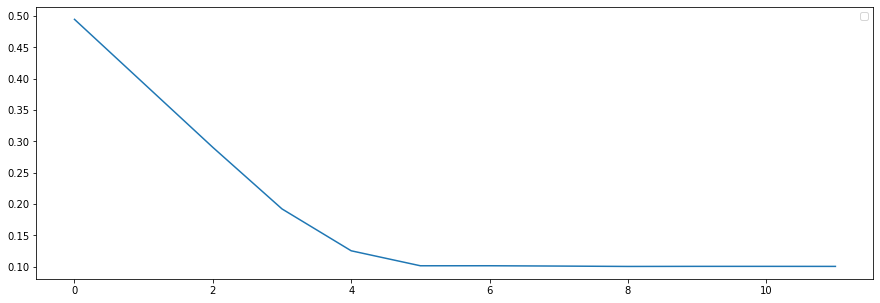

In [208]:
loss, mse = ARNN.evaluate(inputs_test, labels_test, verbose=0)
print('test loss:', loss)
print('test MSE:', mse)

# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.legend()
plt.savefig(fname="../../figures/training_loss.jpg")
plt.show()

In [209]:
# Visualization etc
y_pred_out = ARNN.predict(inputs_train)

mins = pd.read_csv("../../data/cleaned/mins.csv")
maxes = pd.read_csv("../../data/cleaned/maxes.csv")
min_unemployment_rate = mins.unemployment_rate[0]
max_unemployment_rate = maxes.unemployment_rate[0]

#=======================================================  inverting scaling
def inverting_transform_unemployment(series, ls=-1):
    series = series * (max_unemployment_rate - min_unemployment_rate) + min_unemployment_rate
    return series

y_pred_lstm_E = inverting_transform_unemployment(y_pred_out)
y_inv = inverting_transform_unemployment(labels_test.values.reshape(labels_test.shape[0], 1))

In [210]:
months_df = pd.read_csv("../../data/cleaned/unemp_inputs_test_det.csv").date

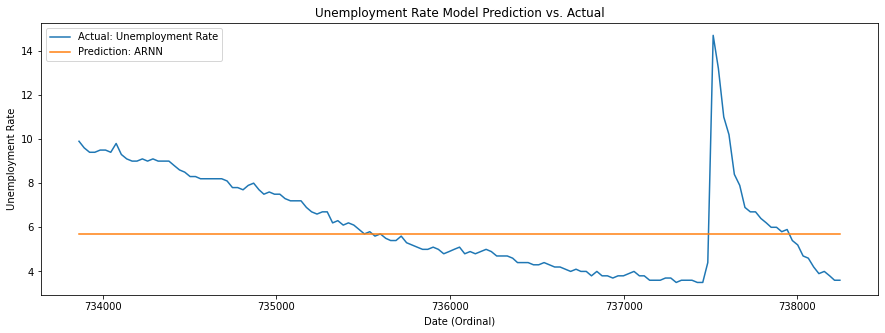

In [211]:

plt.figure(figsize=(15, 5))
plt.plot(months_df, y_inv, label='Actual: Unemployment Rate')
plt.plot(months_df, y_pred_lstm_E[:145], label='Prediction: ARNN')
plt.ylabel('Unemployment Rate')
plt.xlabel('Date (Ordinal)')
plt.title('Seasonally Adjusted Unemployment Rate Prediction vs. Actual: January 2010 to February 2022')
plt.savefig('../../figures/lstm_prediction_vs_actual.jpg')
plt.legend()
plt.show()

In [212]:
# def lstm_net(X_train_in, y_train, X_test_in, y_test):
    
#     model, history = fit_network(verbosity=0)
#     y_pred_out = model.predict(X_test_in)

#     # invert scaling for forecast and actual
#     y_pred = inverting(y_pred_out)
#     y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#     # metrics
#     rmse = sqrt(MSE(y_inv, y_pred))
#     LSTM_accuracy = r2_score(y_inv, y_pred)
#     mean_da = mda(y_inv, y_pred)
    
#     return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

# import time
# from tqdm import tqdm
    
# rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
# for i in tqdm(range(11)):  #31
#     tqdm._instances.clear()
    
#     rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test)
    
#     rmse_l.append(rmse)
#     y_inv_l.append(y_inv)
#     y_pred_l.append(y_pred)
#     acc_l.append(acc)
#     mda_l.append(mdacc)
    
# # getting the index of the median rmse value and extract the predictions of this value
# rsme_df = pd.DataFrame(rmse_l)
# rsme_med = pd.DataFrame(rmse_l).median().values[0]
# ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
# y_pred_lstm = y_pred_l[ind_med]

# fig, ax = plt.subplots(1, 3, figsize=(15,5))
# pd.DataFrame(rmse_l, columns=['RMSE']).boxplot(figsize=(7,6), ax=ax[0])
# pd.DataFrame(acc_l, columns=['Accuracy']).boxplot(figsize=(7,6), ax=ax[1])
# pd.DataFrame(mda_l, columns=['MDAccuracy']).boxplot(figsize=(7,6), ax=ax[2])
# # plt.savefig('RMSE.pdf')
# plt.show()